# Modeling and Simulation in Python

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth orbit


In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
year = UNITS.year

<Unit('year')>

In [3]:
# And an inition condition (with everything in SI units)

# distance from the sun to the earth at perihelion
R = Vector(147e9, 0) * m

# initial velocity
V = Vector(0, -30300) * m/s

init = State(R=R, V=V)

,values
R,"[147000000000.0 meter, 0.0 meter]"
V,"[0.0 meter / second, -30300.0 meter / second]"


In [4]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

t_end = (1 * year).to_base_units()

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_end=t_end)

,values
init,"R [147000000000.0 meter, 0.0 me..."
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_end,31556925.9747 second


In [5]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    
    returns: Vector
    """
    R, V = state
    G, m1, m2 = system.G, system.m1, system.m2
        
    # make sure the result is a vector, either
    # by forcing it, or by putting v.hat() on
    # the left
    
    force = -G * m1 * m2 / R.mag2 * R.hat()
    return Vector(force)

    force = -R.hat() * G * m1 * m2 / R.mag2
    return force

In [6]:
universal_gravitation(init, system)

array([-3.6686486e+22, -0.0000000e+00]) <Unit('newton')>

In [7]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    R, V = state

    F = universal_gravitation(state, system)
    A = F / system.m2
    
    return V, A

In [8]:
# Always test the slope function!

slope_func(init, 0, system)

(array([     0., -30300.]) <Unit('meter / second')>,
 array([-0.00614308, -0.        ]) <Unit('newton / kilogram')>)

In [9]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    R, V = state
    return R.mag - system.r_final

In [10]:
# Always test the event function!

event_func(init, 0, system)

146298121000.0 <Unit('meter')>

In [11]:
# Finally we can run the simulation

system.set(dt=system.t_end/1000)
results, details = run_euler(system, slope_func)
details

,values
message,Success


In [12]:
def plot_trajectory(R):
    x = R.extract('x') / 1e9
    y = R.extract('y') / 1e9

    plot(x, y)
    plot(0, 0, 'yo')

    decorate(xlabel='x distance (million km)',
             ylabel='y distance (million km)')

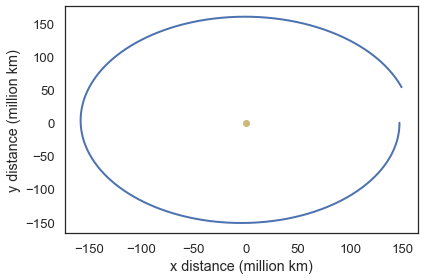

In [13]:
plot_trajectory(results.R)

In [14]:
error = results.last_row() - system.init

R    [1993548154.0907593 meter, 53558254525.37807 m...
V    [9671.881139414403 meter / second, 2805.422229...
dtype: object

In [15]:
error.R.mag

53595343660.133934 <Unit('meter')>

In [16]:
error.V.mag

10070.535172486145 <Unit('meter / second')>

In [17]:
# Ralston

system.set(dt=system.t_end/1000)
results, details = run_ralston(system, slope_func)
details

,values
success,True
message,The solver successfully reached the end of the...


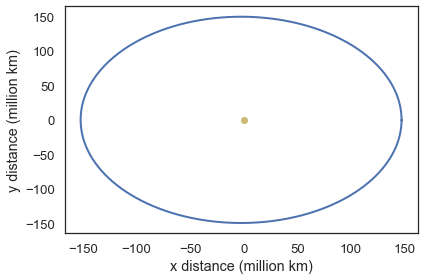

In [18]:
plot_trajectory(results.R)

In [19]:
error = results.last_row() - system.init

R    [-3723637.7203674316 meter, -1060434466.552573...
V    [-214.86614651603597 meter / second, 0.7785432...
dtype: object

In [20]:
error.R.mag

1060441004.1725632 <Unit('meter')>

In [21]:
error.V.mag

214.8675569931363 <Unit('meter / second')>

In [24]:
xs = results.R.extract('x') * 1.1
ys = results.R.extract('y') * 1.1

def draw_func(state, t):
    set_xlim(xs)
    set_ylim(ys)
    x, y = state.R
    plot(x, y, 'b.')
    plot(0, 0, 'yo')
    decorate(xlabel='x distance (million km)',
             ylabel='y distance (million km)')

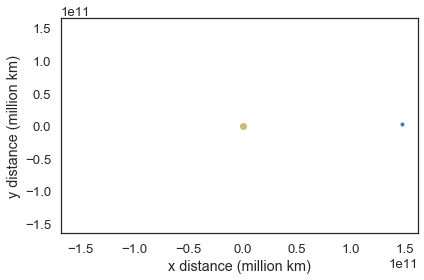

In [25]:
system.set(dt=system.t_end/100)
results, details = run_ralston(system, slope_func)
animate(results, draw_func)